# Music Genre Recognition

## Motivation

Music genre recognition is a prominent and important task in Music Information retrieval.
<br>
The basic idea behind this project is to determine how the different audio features of a song contribute in deciding the genre of the song. We plan to establish this relationship between the different features and the genre.
<br>
<br>
A black box task as it may seem at first, we have tried to visually analyze the features and perform clustering to get a sense of how the audio features are related to the genres.
<br>

## Data description
The data is subset of FMA (Free Music Archive : A dataset for Music Analysis) dataset.
<br>

There are two files from which we extract relevant data.
<br>
1. echonest.csv - This contains the audio features that have been computed for the song. This is provided by Spotify.
<br>
2. tracks.csv = This contains the metadata of the songs and the only relevant column from here is the target variable - 'genre'.


## Feature Description :

Target Variable : Genre
<br>
<br>
Predictors or features :
<br>
1. acousticness
<br>
2. danceability
<br>
3. energy
<br>
4. instrumentalness
<br>
5. liveness
<br>
6. speechiness
<br>
7. tempo
<br>
8. valence
<br>


## Let's start with importing the dataset

In [11]:
from __future__ import print_function
import os
import numpy as np
from sompy.sompy import SOMFactory

In [2]:
import numpy as np;
import pandas as pd;
import warnings
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
warnings.filterwarnings('ignore')
# Import the data
tracks = pd.read_csv("../Data/tracks.csv",low_memory=False,header = [0,1],index_col=0)
echonest = pd.read_csv("../Data/echonest.csv",low_memory = False,header = [0,1,2],index_col=0)

In [3]:
tracks.index.rename("Track_ID",inplace=True)
echonest.index.rename("Track_ID",inplace=True)
echonest_audio_features = echonest['echonest', 'audio_features']
echonest_audio_features.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
Track_ID,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


Merging the data from the two files.

In [4]:
data_with_target = pd.merge(echonest_audio_features,tracks.iloc[:,tracks.columns.get_level_values(1).isin(["genre_top"])],how = "left",left_index = True , right_index = True)
data_with_target.head()
#renaming the target variable:
data_with_target.index.name
data_with_target.rename(columns = {('track', 'genre_top') : "Target_Genre"},inplace = True)
data_with_target.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,Target_Genre
Track_ID,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop


## Data preparation

Checking if any columns have NULL values

In [5]:
def nullColumns(dataset):
    null_columns = []
    for column in dataset.columns.tolist():
        if(dataset[column].isnull().sum() > 0):
            print(column)
            null_columns = null_columns.append(column)
nullColumns(data_with_target)

Target_Genre


As the target variable is missing for certain observations, we decided to drop those observations so as to reduce the noise in the data.
<br>
Since the target variable is categorical, it is not possible to fill the missing values with mean, hence the best choice we thought is to remove those certain rows.

In [6]:
def dropNull(dataset, null_list):
    dataset.dropna(axis=0,how='any', inplace = True)
    return dataset

data_with_target = dropNull(data_with_target, nullColumns)
print('The shape of  target variable after dropping NAN is', data_with_target.shape)
print('\nThe number of unique values in target variable after dropping NAN is\n',data_with_target.nunique())
print('\n\nThe value counts of each target variable after dropping NAN is\n',data_with_target.Target_Genre.value_counts())

The shape of  target variable after dropping NAN is (9355, 9)

The number of unique values in target variable after dropping NAN is
 acousticness        9163
danceability        9355
energy              9355
instrumentalness    9249
liveness            9354
speechiness         9355
tempo               8791
valence             9353
Target_Genre          12
dtype: int64


The value counts of each target variable after dropping NAN is
 Rock                   3892
Electronic             2170
Hip-Hop                 910
Folk                    874
Old-Time / Historic     357
Pop                     346
Classical               265
Jazz                    241
International           133
Instrumental             84
Blues                    66
Experimental             17
Name: Target_Genre, dtype: int64


## Tokenizing Target Variable

Since the target variable is categorical, we need to tokenize it.
<br>
This is performed using LabelEncoder() function provided by sklearn

In [7]:
print("Unique genres before tokenizing : \n" ,np.unique(list(data_with_target.Target_Genre)))
genres = list(set(list(data_with_target.Target_Genre)))
#LabelEncoding the target variable
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data_with_target['Target_Genre'])
data_with_target['Target_Genre'] = le.transform(data_with_target['Target_Genre'])
print("After tokenizing : ",np.unique(list(data_with_target.Target_Genre)))

Unique genres before tokenizing : 
 ['Blues' 'Classical' 'Electronic' 'Experimental' 'Folk' 'Hip-Hop'
 'Instrumental' 'International' 'Jazz' 'Old-Time / Historic' 'Pop' 'Rock']
After tokenizing :  [ 0  1  2  3  4  5  6  7  8  9 10 11]


## Feature Engineering
### Finding the correlation between the features

We try to find the correlation between all the features to get a sense of how are they related to each other.

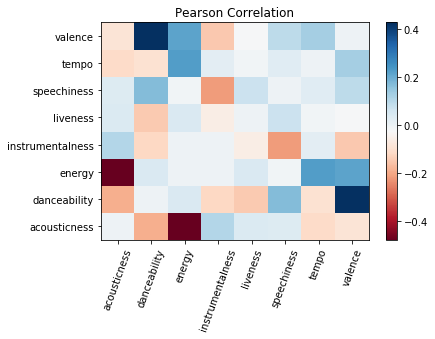

In [8]:
from matplotlib import pyplot as plt

def correlationHeatMap(dataset):
    c_mat = dataset.corr()
    for i in range(c_mat.shape[0]):
        c_mat.iloc[i,i] = 0
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(c_mat, cmap=plt.cm.RdBu)
    ax.set_xticks(np.arange(c_mat.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(c_mat.shape[1])+0.5, minor=False)
    ax.set_xticklabels(c_mat.index.values,  rotation = 70, minor=False)
    ax.set_yticklabels(c_mat.index.values, minor=False)
    plt.title('Pearson Correlation')
    cbar = plt.colorbar(heatmap)
    plt.show()

correlationHeatMap(echonest_audio_features)

Key Insights from the correlation maps:
<br>
<br>
1. valence and dancebility are positively correlated. 
<br>
2. tempo and enery are positively correlated.
<br>
3. enery and acousticness are negatively correlated.
<br>
4. speechiness and instrumentalness are negatively correlated.
<br>
5. dancebility and acousticness are negatively correlated.
<br>

We also try to analyze the data and see if the analysis supports the correlation between features found above.

In [9]:
#Preparing data for Self Organizing Maps
data = echonest_audio_features.as_matrix()
names = echonest_audio_features.columns

## Analyzing features using Self Organizing Maps

There are a lot of analytical methods for analyzing data. Classical statistical methods generally include hypothesis testing, linear regression. Machine learning methods include Random Forests , Bagging and other ensemble methods.
<br>
<br>
There are also different visual techniques that can be used for data analysis. They are basically classified into two types:
<br>
1. Univariate representations which produce representations of one variable. Examples of this are histograms, box-whisker plots etc.
<br>
2. Multivariate representations try to establish and visualize the relationship between several variables. Example of this method is Self Organizing Maps (Kohonen maps).

### Basic Theory

1. There are 'n' input neurons corresponding to the 'n' data points which are mapped to 2-dimensional topological map of competing neurons.
<br>
2. Generally the compteting neurons are arranged in a 2 dimensional lattice; they are located at the corners of the lattice.
<br>
3. Each competing neuron is connected to all the input neurons.
<br>
4. There is a N-dimensional weight vector associated to each link between the input and the compteting neuron where N is the number of dimensions of the input data.
<br>
5. The competing neuron which is closest to a particular training data is called as the winning neuron and the neurons in the topographic neighborhood of this winning neuron are called as the exciting neurons. The closeness is determined by the distance between the input data point and the weight link associated with the winning neuron and the input data. This distance is calculated in the N-dimensional space. (Generally Euclidean distance is used for the same)
<br>
6. This winning neuron is called as the Best Matching Unit (BMU) for that input data.
<br>
7. The weight is updated after the BMU for a particular data point is found. The weights of the excited neurons and the input data point are also updated. This is to ensure the topological structure is maintained.
<br>
8. This process is generally carried out in two steps : Rough training and Fine training.
<br>
9. The rough training phase has a large initial learning rate and a large neighborhood radius for considering excited neurons.
<br>
10. Fine training phase has a small learning rate and a small neighborhood radius for considering excited neurons.

### Determining the quality of the Self Organizing Map

The quality of the SOM is determined by generally two metrics.
<br>
1. Quantization error : Measures the distance between each training poing and it's best matching unit. It measures map resolution.
<br>
2. Topographic error : Measures the proportion of data points for which the first and the second best matching units are not adjacent to each other.

### Implementing Self Organizing Maps

Using Sompy library in python to implement Self Organizing Maps.
<br>
1. build is a static function of the class SOMFactory
<br>
2. Data is the input data which has to be a matrix where rows are the training points and columns represent the features.
<br>
3. Initialization can be pca or random. PCA gives better results over random. 
<br>
4. Normalization uses Variance. The covariance matrix of the input data is used for finding the first two eigen values and eigen vectors for pca of the data.
<br>
5. The topographic map is initialized by the first two eigen values only.
<br>
<br>
We tried random initializations as well, but pca initialization performs better than random. Hence pca initialization is used.


In [12]:
sm = SOMFactory.build(data,mapsize = (30,30) ,normalization = 'var', initialization = 'pca',component_names=names)

 * Since we are not parallelizing the alogrithm, n_jobs = 1 and no shared memory. 
<br>
 * train_rough_len is the number of iterations for rough training
<br>
 * train_finetune_len is the number of iterations for fine training
<br>

In [13]:
sm.train(n_job = 1, shared_memory='no',verbose = 'info',train_rough_len=10, train_finetune_len=100)

 Training...
 pca_linear_initialization took: 0.036000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  0.244000, quantization error: 2.075952

 epoch: 2 ---> elapsed time:  0.236000, quantization error: 1.948372

 epoch: 3 ---> elapsed time:  0.238000, quantization error: 1.762683

 epoch: 4 ---> elapsed time:  0.235000, quantization error: 1.606740

 epoch: 5 ---> elapsed time:  0.234000, quantization error: 1.502959

 epoch: 6 ---> elapsed time:  0.234000, quantization error: 1.431856

 epoch: 7 ---> elapsed time:  0.232000, quantization error: 1.366100

 epoch: 8 ---> elapsed time:  0.232000, quantization error: 1.298884

 epoch: 9 ---> elapsed time:  0.236000, quantization error: 1.229540

 epoch: 10 ---> elapsed time:  0.238000, quantization error: 1.159209

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.231000, quantization error: 1.083262



In [14]:
topographic_error = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print ("Topographic error = %s\nQuantization error = %s" % (topographic_error, quantization_error))

Topographic error = 0.0
Quantization error = 1.02038650261


### Components Map
<br>
The components map or the components plane provides qualitative information about how the input variables are related to each other for the given dataset. 
<br>
<br>
The color code represents quantitative information about a particular feature and comparision of the component maps of two or more features sheds light on how these features are related to each other.

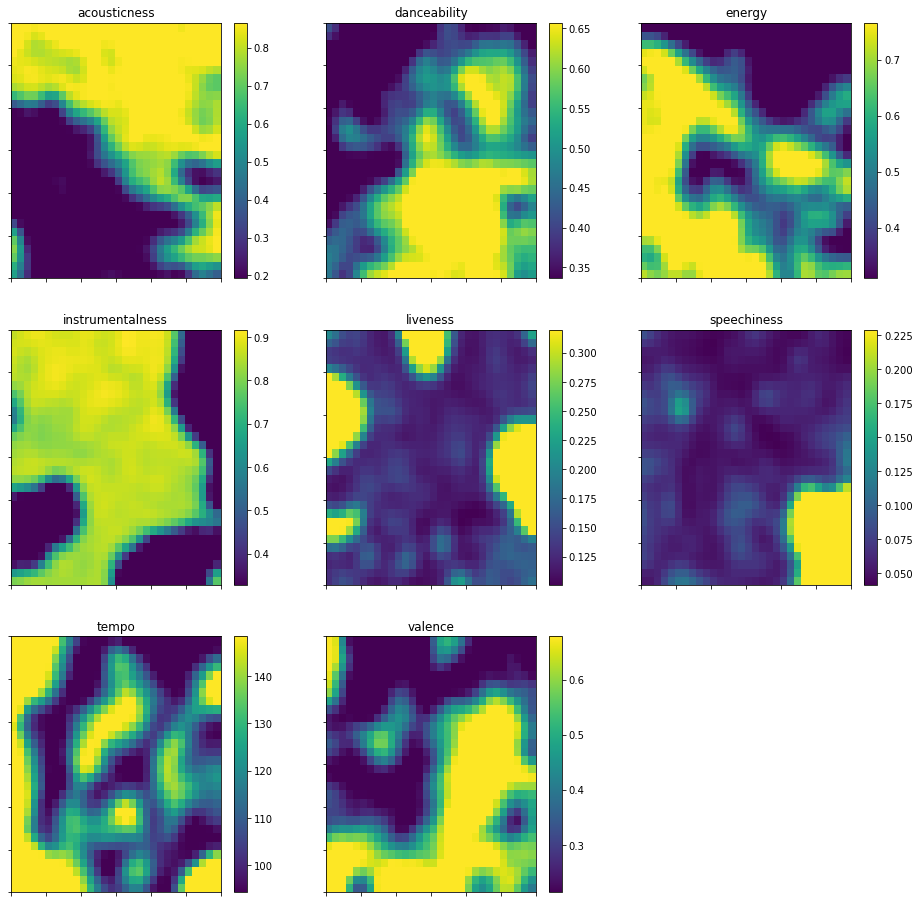

In [15]:
from sompy.visualization.mapview import View2D
view2D  = View2D(20,20,title = 'Yes',text_size=10)
view2D.show(sm, col_sz=3, which_dim="all", desnormalize=True)

### Analysis from component maps 
<br>
Important analysis from the component maps are :
<br>
1. Acoustiness and energy are negatively correlated. Points that have high acoustiness generally have low energy and vice versa.
<br>
2. Points having high tempo have high energy.
<br>
3. High dancebility points generally have high energy as well.
<br>
4. Valence and dancebility are positively correlated.
<br>
5. Points having high dancebility values have low acousticness value.
<br>
6. Points having high speechiness value have low instrumentalness value.

## Comparision between Pearson's correlation coefficient and component maps of SOM

<br>
Analysis of the feature correlation is performed by the two methods :
<br>
1. Pearson's correlation coefficient.
<br>
2. Component Map analysis after applying Self Organizing Maps.
<br>
Both the analysis support each other. 
<br>
 * Pearson's correlation coefficient gives a quantitative measure of the correlation between the features.
< br>
 * Self Organizing Maps help visualize the features to obtain the correlation.
 

### Hit Map View
1. Hit map view provides quantitative information about how many times each map unit or competitive neuron was the Best Matching Unit for the input data.
<br>
2. This gives an idea of how many input data points are closely associated to a particular competitive neuron in the 2-dimensional topographic space.
<br>
3. This sheds some light on the relative importance of the competitive neurons for the given dataset.


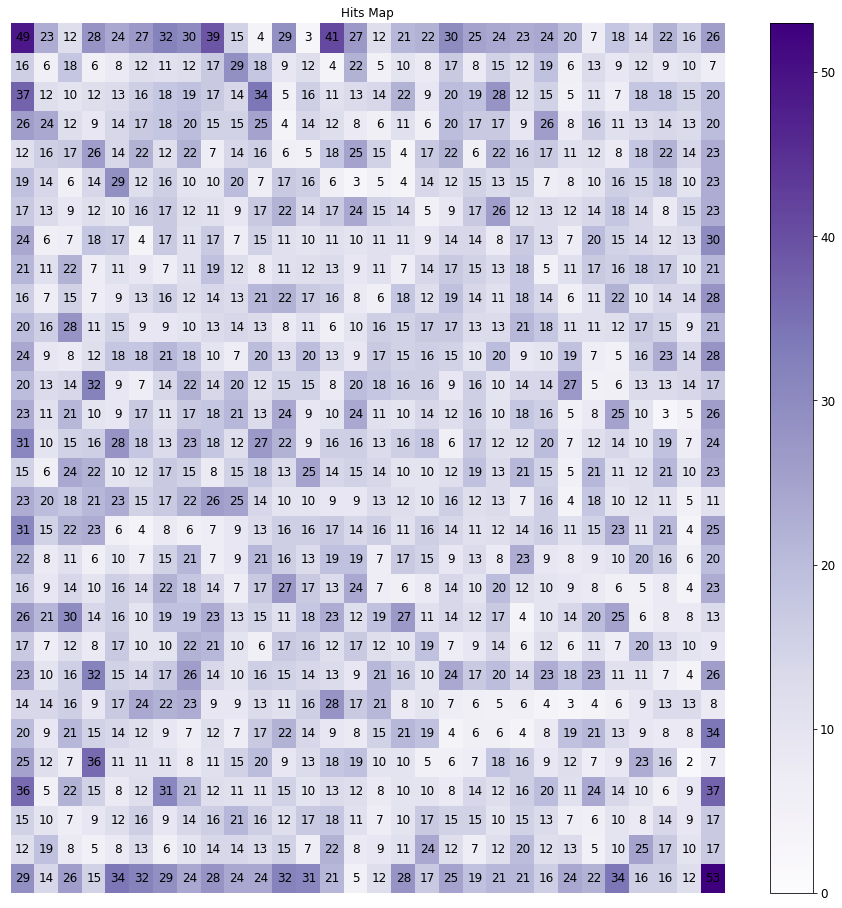

In [16]:
from sompy.visualization.bmuhits import BmuHitsView
vhts  = BmuHitsView(3,3,"Hits Map",text_size=12)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Purples", logaritmic=False)

##  Cluster the data using K-means clustering
<br>
The data is clustered using k-means clustering.
<br>
1. Number of clusters chosen here is 12 since there are 12 unique genres in the dataset.
<br>
2. The default parameter used for clustering in the library is k = 8.
<br>
3. However since a mapsize of 24 x 24 was considered, the clusters are not very prominent for all the genres.
<br>
4. Interesting analysis however is that genres 'Rock' and 'International' are close. They represent similar acoustic measures.
<br>
5. Similar is the case with genres 'Blues' and 'Pop'.
<br>
<br>
Genres represented by labels are :
<br>
0 : 'Rock'
<br>
1 : 'Electronic'
<br>
2 : 'Classical'
<br>
3 : 'Folk'
<br>
4 : 'Hip-Hop'
<br>
5 : 'Blues'
<br>
6 : 'International'
<br>
7 : 'Instrumental'
<br>
8 : 'Experimental'
<br>
9 : 'Pop'
<br>
10 : 'Old-Time / Historic'
<br>
11 :  'Jazz'

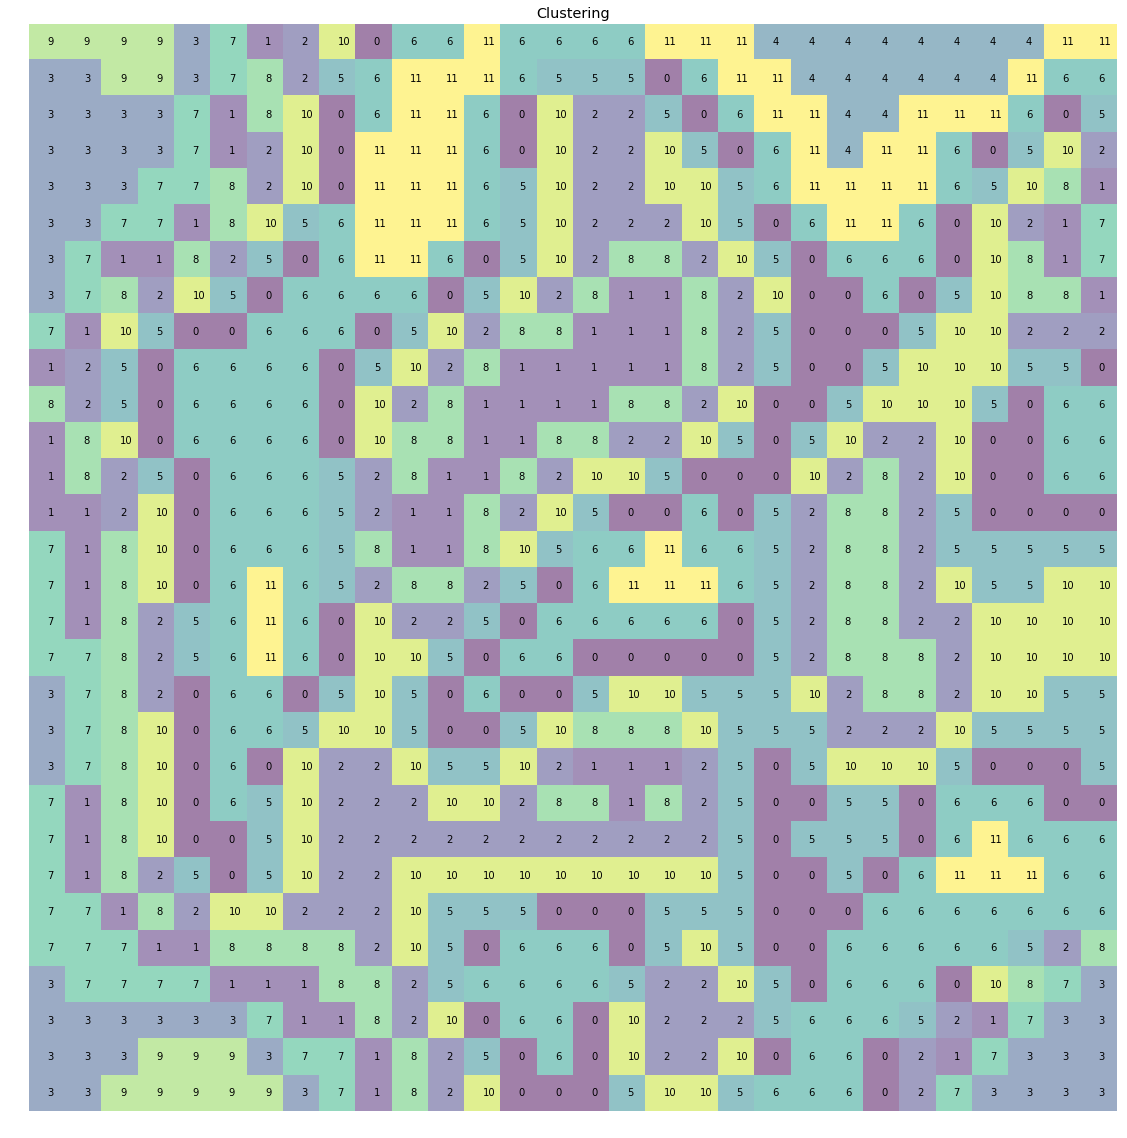

In [17]:
from sompy.visualization.hitmap import HitMapView
sm.cluster(12)
hits  = HitMapView(20,20,"Clustering",text_size=15)
a=hits.show(sm)

## Data Preprocessing for Modelling

In [18]:
#checking for the skewed columns
def skewColumns(dataset, target):
    dataset = dataset.drop(target, axis =1)
    skew_columns = (dataset.skew().sort_values(ascending=False))
    skew_columns = skew_columns.loc[skew_columns > 0.75]
    print(skew_columns)
    return skew_columns

Since some features are skewed we perform log transformation for removing the skewness.
<br>
This ensures that there is less variance in data and the data conforms more closely to the normal distribution.

In [19]:
#Perform log transform on skewed columns
def skewTransform(dataset, target):
    skew_columns = skewColumns(dataset, target)
    for col in skew_columns.index.tolist():
        dataset[col] = np.log1p(dataset[col])
    return dataset

#skew_columns = skewColumns(echonest_audio_features, 'genre')
echonest_audio = skewTransform(data_with_target,'Target_Genre' )

speechiness    3.422018
liveness       2.279073
dtype: float64


Scaling the feature values to ensure uniformity

In [20]:
from sklearn.preprocessing import StandardScaler
def featureScaling(dataset, target):
    sc = StandardScaler()
    dataset_scaled = pd.DataFrame(sc.fit_transform(dataset.drop(target, axis=1)), 
                                  index = dataset.index, columns = dataset.drop(target, axis=1).columns)
    dataset_scaled[target] = dataset[target]
    return dataset_scaled
echonest_audio = featureScaling(data_with_target,'Target_Genre')

In [21]:
print("Data after scaling : ")
echonest_audio.head()

Data after scaling : 


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,Target_Genre
Track_ID,,,,,,,,,
2,-0.305190,1.081472,0.335174,-1.802354,-0.033418,0.547961,1.209559,0.520177,5
3,-0.414637,0.309857,0.981693,-1.826925,-0.555945,2.734133,0.105597,-0.594694,5
5,-1.271315,1.446562,0.571875,-1.830157,1.242922,0.261302,-0.650787,0.683372,5
10,1.080124,0.988641,1.359970,0.870650,-0.484161,-0.539885,-0.330577,1.923387,10
134,-0.213157,0.229133,0.073484,-1.777677,-0.626228,3.136317,-0.253287,1.671279,5


## Determining Feature Importance using Decision Tree Classifier


acousticness -> 0.3639568852190641

danceability -> 0.17271580390780825

energy -> 0.1327569935906687

instrumentalness -> 0.08380756663017316

liveness -> 0.030013107125120297

speechiness -> 0.16654761875457222

tempo -> 0.022683662720733244

valence -> 0.02751836205185997



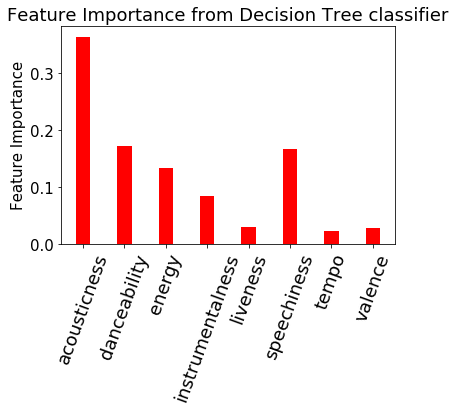

In [22]:
clf = DecisionTreeClassifier(criterion='entropy',min_samples_leaf=100,max_depth=20)
clf = clf.fit(echonest_audio.drop('Target_Genre', axis =1), echonest_audio['Target_Genre'])
#sklearn also has build-in means to check which feature contributes more to the prediction.
importances = clf.feature_importances_
features = list(echonest_audio.columns)
features = features[:-1]

fig, ax = plt.subplots()
width = 0.35
ax.bar(range(len(importances)), importances, width, color='r')
ax.set_xticks(np.arange(len(clf.feature_importances_)))
ax.set_xticklabels(echonest_audio.drop('Target_Genre',1).columns.tolist(), rotation = 70, fontsize='large')
plt.title('Feature Importance from Decision Tree classifier')
ax.set_ylabel('Feature Importance')
for i in range(len(features)):
    print("{} -> {}\n".format(features[i],importances[i]))

## Supervised Learning Approach

In [23]:
from sklearn.model_selection import train_test_split

#splitting the data into train and test
train,test = train_test_split(echonest_audio,test_size = 0.3,random_state = 100)

x_train = train.drop('Target_Genre', axis=1)
y_train = train['Target_Genre']
x_test = test.drop('Target_Genre', axis =1)
y_test = test['Target_Genre']

## Gradient Boosting Classifier

Hypertuning the parameters for the GradientBoosting Classifier

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through all of the possibilities for number of estimators
tree_list = [15, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, 
                                     subsample=0.5,
                                     max_features=4,
                                     random_state=42)

    # Fit the model
    GBC.fit(x_train.values, y_train.values)
    y_pred = GBC.predict(x_test)

    # Get the error
    error = 1. - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

Finding the optimal number of trees for GradientBoosting by plotting the error vs number of trees

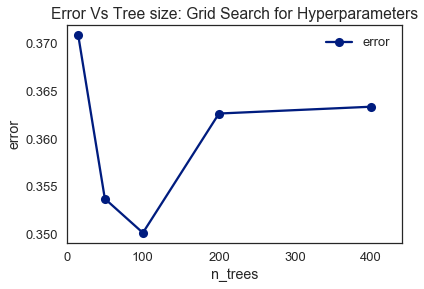

In [25]:
import seaborn as sns

sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')


ax = error_df.plot(marker='o')

ax.set(title='Error Vs Tree size: Grid Search for Hyperparameters')
ax.set(xlabel='n_trees', ylabel='error')
ax.set_xlim(0, max(error_df.index)*1.1);

The minimum error is at 100 tree value

In [26]:
from sklearn.model_selection import GridSearchCV

#range of parameters for training the model
param_grid = {'n_estimators': [50,100,200,400],
              'learning_rate': [0.1, 0.01]}

# Grid search for Hyper Parameters
GV_GBC = GridSearchCV(GradientBoostingClassifier(subsample=0.5,
                                                 max_features=4,
                                                 random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# fitting the data to perform grid search
GV_GBC = GV_GBC.fit(x_train, y_train)

In [27]:
from sklearn.metrics import classification_report

#predict using the grid search
y_pred_gbc = GV_GBC.predict(x_test)
accuracy_xgb = accuracy_score(y_test,y_pred_gbc)
print("Accuracy for GradientBoosting is {}".format(accuracy_xgb*100))
print("\nClassification report for GradientBoosting : ")
print(classification_report(y_pred, y_test))

Accuracy for GradientBoosting is 65.33665835411472

Classification report for GradientBoosting : 
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         5
          1       0.63      0.66      0.64        86
          2       0.62      0.68      0.65       603
          3       0.00      0.00      0.00         0
          4       0.39      0.42      0.40       253
          5       0.61      0.65      0.63       243
          6       0.00      0.00      0.00         8
          7       0.14      0.36      0.20        14
          8       0.07      0.13      0.09        38
          9       0.88      0.90      0.89       107
         10       0.07      0.26      0.11        27
         11       0.82      0.66      0.73      1423

avg / total       0.69      0.64      0.66      2807



Trying Extreme Gradient Boosting for the data

### XGBoost model

In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

#Buiding a Model
xgb = XGBClassifier()
xgb.fit(x_train,y_train)

#Predicting the target Genre
y_predicted = xgb.predict(x_test)
accuracy_xgb = accuracy_score(y_test,y_predicted)
print('The accuracy achieved with XGBClassifier is {}'.format(accuracy_xgb*100))

The accuracy achieved with XGBClassifier is 65.1585322408265


Confusion Matrix for XGBoost

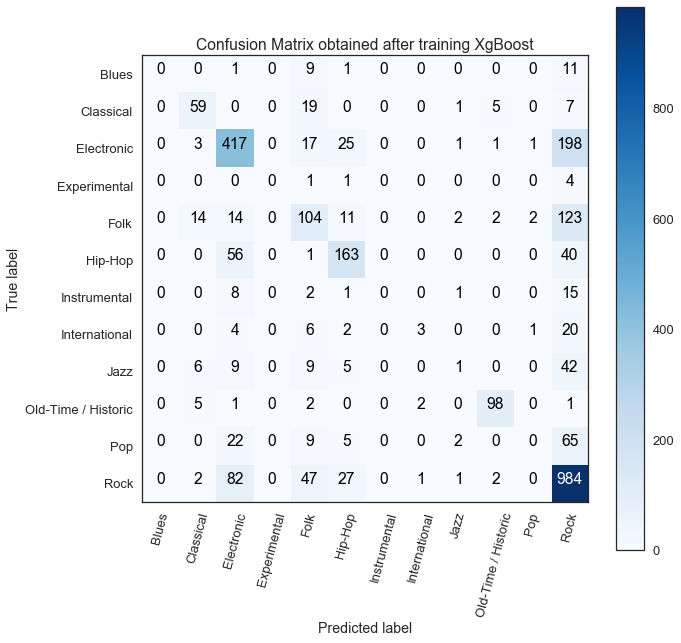

In [29]:
class_names = [le.inverse_transform(data_with_target['Target_Genre'])]
class_name = np.unique(class_names)

import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=75)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predicted)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
#plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_name,
                      title='Confusion Matrix obtained after training XgBoost')

plt.show()

Interpretations from Confusion Matrix:
There are four categories for which the model is not able to predict correctly Pop, Instrumental, Experimental and Blues. This is not due to imbalance in dataset as other categories with higher number than Pop have a f1-scores scores.

## Results of XGBoost

In [30]:
from sklearn.metrics import classification_report
y_pred = xgb.predict(x_test)
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.65      0.66      0.66        89
          2       0.63      0.68      0.65       614
          3       0.00      0.00      0.00         0
          4       0.38      0.46      0.42       226
          5       0.63      0.68      0.65       241
          6       0.00      0.00      0.00         0
          7       0.08      0.50      0.14         6
          8       0.01      0.11      0.02         9
          9       0.90      0.91      0.90       108
         10       0.00      0.00      0.00         4
         11       0.86      0.65      0.74      1510

avg / total       0.74      0.65      0.69      2807



Comparing the classification report for XGBoost and Gradient Boost, 
we observe that XGBoost gives a better precision, recall and F1 score as compared to Gradient boost. This is probably because in Gradient boost we specify the hyperparameters and it may return locally best estimator based on our tuning
But, XGBoost performs wider search for hyperparameters.

## Conclusion
1. We compared two analytical methods for analyzing the data - Pearson's correlation coefficient and visual technique 'Self Organizing Maps'. We obtained similar analysis from both the methods.
<br>
2. Self organizing maps helped visualize the data in 2-dimensional space. Clustering in the 2-dimensional space helped analyze similarity between the genres.
<br>
3. Supervised learning methods like Gradient boosting and Extreme Gradient Boosting were used for recognizing the genres for the test dataset.
<br>
4. Visualizing the confusion matrix helped understand the mislabelled genres.
